<h1>Modelling nova ejecta in the Milky Way</h1>

In [560]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('thomas')
from IPython.display import Image
import scipy.stats as st

In [556]:
mpl.style.use('thomas')

<h3>Slide 1:</h3>

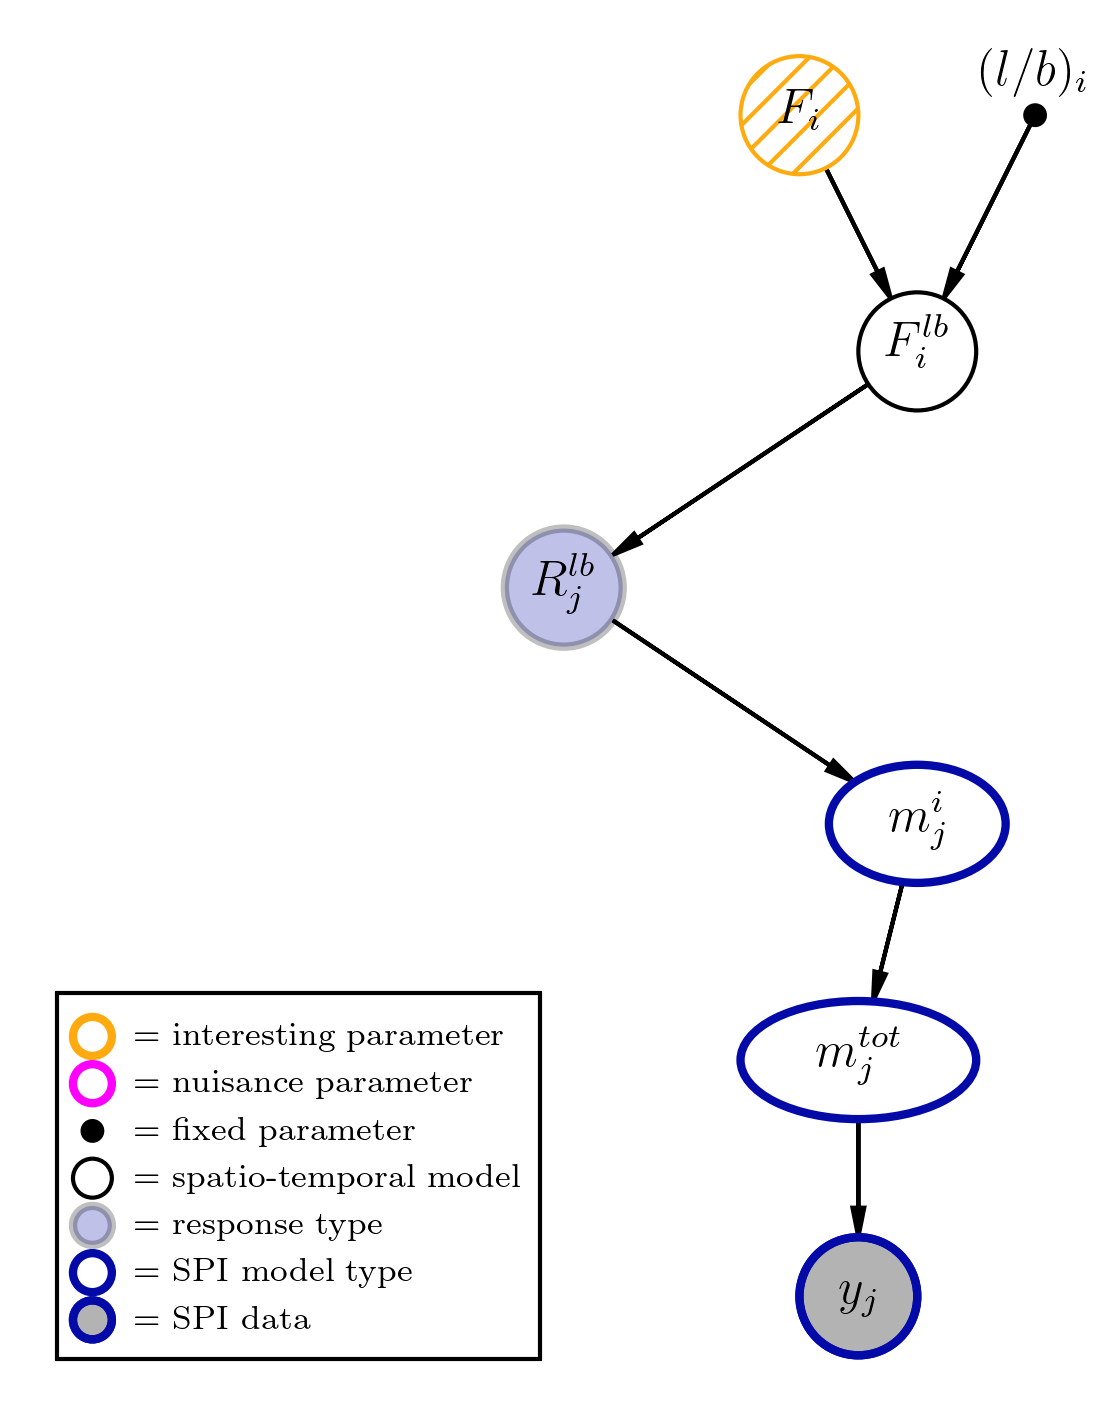

In [558]:
with open('plots/one_nova_flux.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h3>The (astro)-physical (photon) model (as a function of time - not explicitely mentioned here) for a point source $i$ at the (fixed) position $(l/b)_i$ in units of $\mathrm{ph\,cm^{-2}\,s^{-1}}$ is $F_i^{lb}$. It is generically given by<br><br>
    $F_i^{lb} = F_i \cdot \delta(l-l_i) \delta(b-b_i)$.<br><br>
    Through convolution with the instrument response $R_j^{lb}$, the photon model is converted from 'model space' (physical units) into the 'SPI data space' (indexed by $j$, i.e. detectors, pointings) $m_j^i$, i.e.<br><br>
    $m_j^i = R_j^{lb} \otimes F_i^{lb}$, which finally is unitless (number of photons per unit data space entry).<br><br>
    The total model $m_j^{tot}$ is the sum of all models (here still one). It depends linearly on $F_i$ (scaling parameter), and is compared in the analysis to the SPI data $y_j$ through a fit, optimising (sampling the full posterior of) for $F_i$. Since this is a photon counting experiment, the likelihood of observing $y_j$ counts, given the model $m_j^{tot} (=: m_j)$ as a function of its parameter $F_i$, is given by<br><br>
    $\mathscr{L}(D|M(F_i)) = \prod_{j} \frac{m_j^{y_j}e^{-m_j}}{y_j!}$.<br><br>
    To obtain the full posterior we require a prior on $F_i$, which we decide based on our domain expertise, and the goal of the analysis. We know that in most cases, we don't expect the flux to be measureably high, but have to require that it to be positive. We choose a half-Gaussian, restricted to positive values, centred at $0$, with a width as uninformative as needed but as informative as possible. The flux expected is of the order of $10^{-5}\,\mathrm{ph\,cm^{-2}\,s^{-1}}$, as otherwise, INTEGRAL would have already seen it. Our prior thus should cover this range and maybe one order of magnitude larger:<br><br>
    $P(F_i) \propto \mathscr{N}^+(0,10^{-4})$.<br><br>
    (NB: In our Stan model, we want to have similar numbers to not deal with largely varying scales, so that we normalise our convolved sky model $m_j^i$ to $10^{-5}$, and fit a scaling parameter $\alpha_i$ instead, with a prior scaled the same way, i.e. $P(\alpha_i) \propto \mathscr{N}^+(0,10)$.)<br><br>
    The full posterior $\pi(F_i)$, which is sampled by Stan, is finally given by (Bayes' rule)<br><br>
    $\pi(F_i) \propto \mathscr{L}(D|M(F_i))P(F_i)$.</h3>

<h3>Slide 2:</h3>

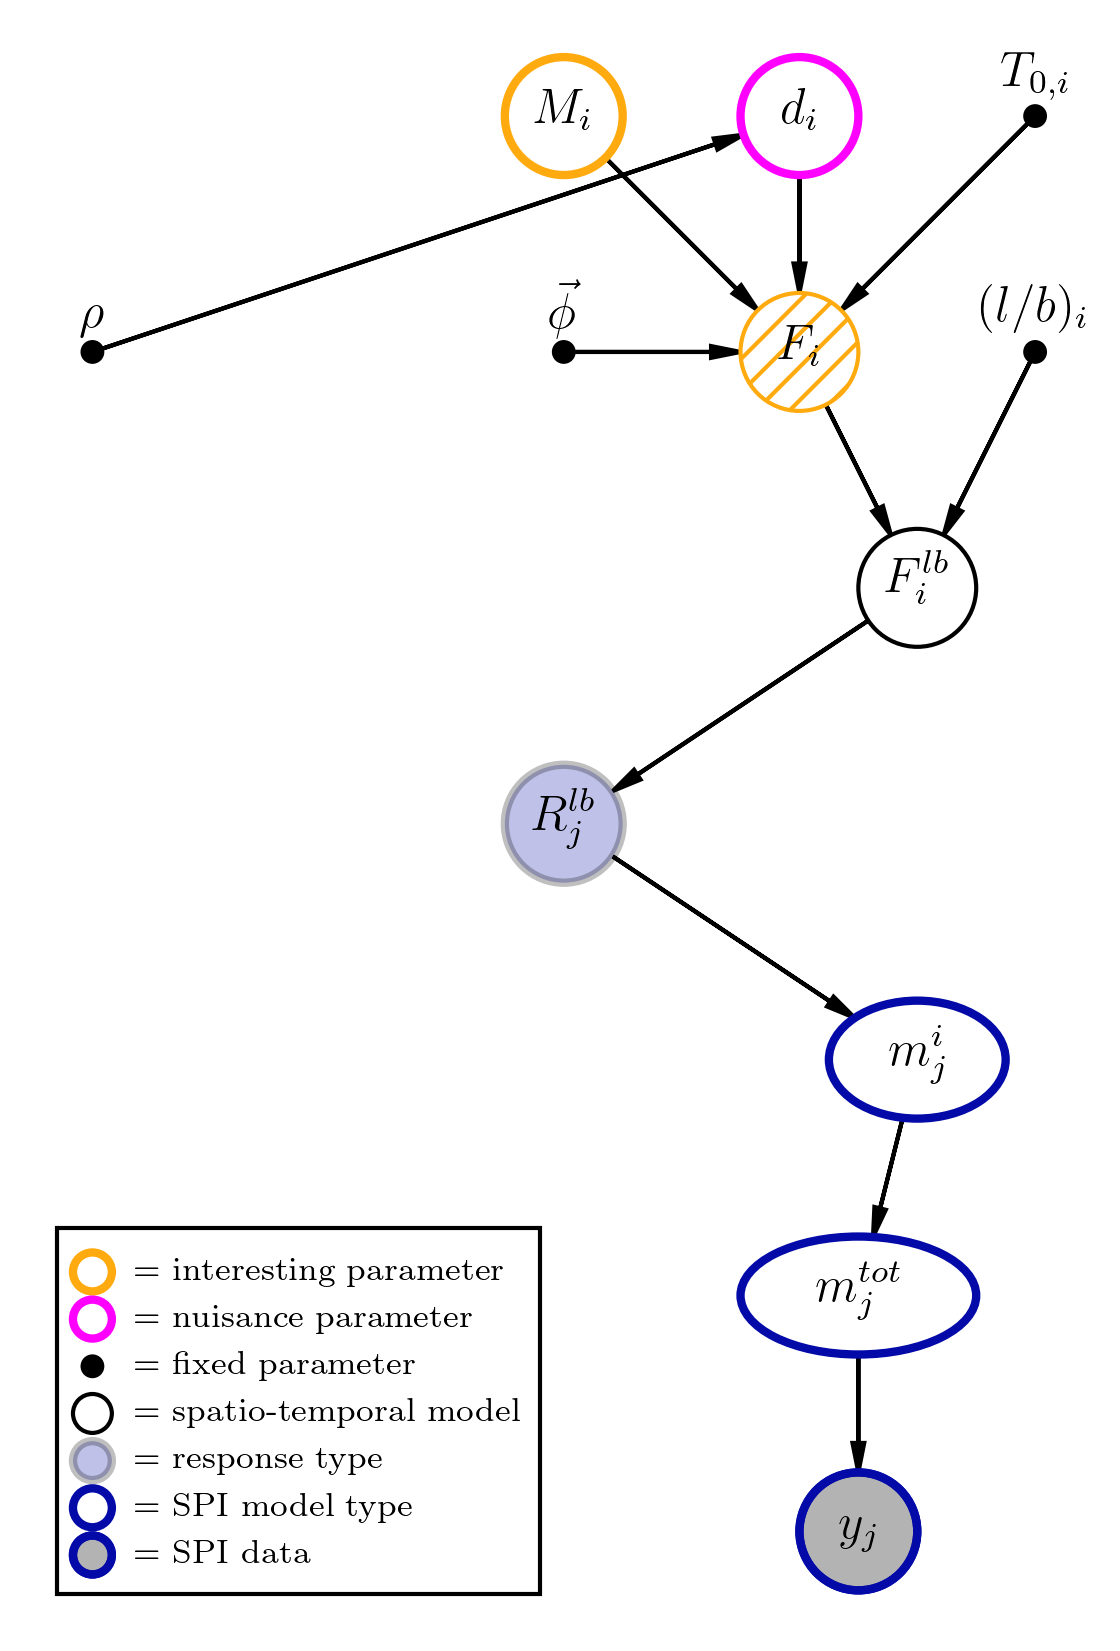

In [559]:
with open('plots/one_nova_mass.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h3>We know that novae are not just sending out photons with flux $F_i$, but that this is related to (astro)physical parameters, some of which are (have to be) fixed, some of which we treat as nuisance parameters (have variance but we don't care), and some of which we are actually interested in and directly impact the measured flux.<br>
    The flux $F_i$ depends on ejected mass $M_i$, the distance of the nova to us $d_i$, when the thing exploded $T_{0,i}$, and several nuclear physics parameter summarised in $\vec{\phi} = \{\tau,m,p\}$, including the decay time of the decaying isotope $\tau$, its nuclear mass $m$, and the probability to actually send out a photon after the decay, $p$.<br>
    We start with the radioactive decay law of the number of particles that decay as a function of time,<br>
    $N_i(t) = N_i \exp(-\frac{t-T_{0,i}}{\tau})$,<br>
    where the initial number of particles $N$ is given by<br>
    $N_i = \frac{M_i}{m}$.<br>
    The activity $A_i(t)$ (number of decays per unit time) is given by the derivate of $N_i(t)$ such that
    $A_i(t) = - \frac{dN_i(t)}{dt} = \frac{M_i}{m\tau} \exp(-\frac{t-T_{0,i}}{\tau})$.<br>
    The number of photons emitted (luminosity $L_i(t)$) is given by<br>
    $L_i(t) = \frac{M_i p}{m\tau} \exp(-\frac{t-T_{0,i}}{\tau})$, so that the flux received at Earth is calculated by<br>
    $F_i(t) = \frac{M_i p}{4 \pi d_i^2 m \tau} \exp(-\frac{t-T_{0,i}}{\tau})$.<br>
    This again is a linear function in $M_i$ (and $d_i^{-2}$), so that our convolved sky model can be scaled directly with $M_i d_i^{-2}$, and we learn something about the ejected mass instead of the emitted flux.<br><br>
    The distances to novae is, most of time, not known, but we 'know' (domain expertise and literature) the distribution of novae in the Milky Way $\rho(x,y,z)$. From this distribution, we can construct a prior distribution for each $d_i$ if it is not otherwise provided.<br>
    This density is given by the combination of two functions, one for the central regions of the Galaxy, a so-called De Vaucouleurs profile $\rho_{DV}(x,y,z)$, and one for the Galactic plane, typically described as a doubly-exponential disk $\rho_{EXP}(x,y,z)$. The total density is a linear combination with unequal weights $w_{DV} = 0.1$ and $w_{EXP} = 0.9$, repectively. The functions are given as follows:<br><br>
    $\rho_{DV}(x,y,z) = \frac{16 a^{17/2}}{2027025 \pi^{3/2} R_e^3} \exp\left(-a \left(\frac{R}{R_e}\right)^{1/4} \right) \left(\frac{R}{R_e}\right)^{-7/8}$ with $R^2 = (x-x_0)^2 + (y-y_0)^2 + (z-z_0)^2$, $a = 7.669$, and $R_e = 2.7\,\mathrm{kpc}$.<br><br>
    $\rho_{EXP}(x,y,z) = \frac{1}{4 \pi r_e^2 z_e} \exp\left(-\left(\frac{|z-z_0|}{z_e}\right) - \left(\frac{r}{r_e}\right)\right)$ with $r^2 = (x-x_0)^2 + (y-y_0)^2$, $z_e = 0.25,\mathrm{kpc}$, and $r_e = 3.5,\mathrm{kpc}$.<br><br>
    $(x_0,y_0,z_0) = (8.178,0,-0.015),\mathrm{kpc}$ is the position of the Galactic Centre as viewed from the Sun.</h3>

<h3>Information flood.<br><br>
    How do we get distances from these densities? Let's investigate this further:<br><br>
    Any nova of which we know happened, but don't know how far away, still follows the spatial distribution of $\rho = w_{DV}\rho{DV} + w_{EXP}\rho{EXP}$. That means, some positions, and consequently distances, are more frequent than others. We need to find the distribution of distances $d = \sqrt{x^2+y^2+z^2}$ that follows from the density $\rho$. This distribution would be our prior for $d_i$, and is solvable (well...) by a very large and ugly triple integral. But let's do something else instead.<br><br>
    Consider, for the moment, a 1D toy-example, and suppose our 'density' is given by the function $\rho'(r) = (r-8)^2+1$ on the interval $[6,10]$ (and $0$ otherwise).<br>
    How do we sample from such a function? $\Longrightarrow$ Rejection sampling!</h3>

In [591]:
# Basically copied 1:1 from the internet

# target function
def p(x):
    return (x-8)**2 + 1

# proposal function
def q(x):
    return st.uniform.pdf(x,loc=6,scale=4)

# range of interest
x = np.linspace(6, 10,100)
# maximum scaling for proposal function
k = max(p(x) / q(x))

# 1) throw a point in this region (between 6 and 10)
# 2) calculate y value of random point (scaled by maximum)
# 3) decide if point is inside distribution (keep) or outside (reject)
def rejection_sampling(n=1000):
    samples = []
    all_points = []
    
    while len(samples) < n:
        z = np.random.uniform(low=6,high=10)
        u = np.random.uniform(0, k*q(z))
        all_points.append([z,u])
        
        if u <= p(z):
            samples.append(z)

    return np.array(samples),np.array(all_points)

In [625]:
# sample 100 points
toy_sample = rejection_sampling(n=100)

In [626]:
# rejection sampling algorithm:
# keep those which are below the line
keep = toy_sample[1][:,1]<=p(toy_sample[1][:,0])
# reject those above
reject = toy_sample[1][:,1]>p(toy_sample[1][:,0])

Text(0, 0.5, 'samples')

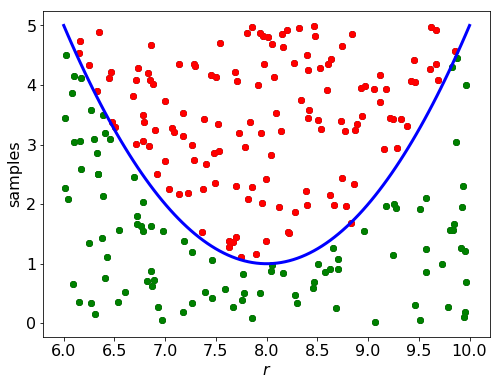

In [627]:
plt.plot(toy_sample[1][:,0],toy_sample[1][:,1],'o')
plt.plot(toy_sample[1][reject,0],toy_sample[1][reject,1],'ro')
plt.plot(toy_sample[1][keep,0],toy_sample[1][keep,1],'go')
plt.plot(x,p(x),color='blue',linewidth=3)
plt.xlabel(r"$r$")
plt.ylabel(r"samples")

In [628]:
# sample 10000 points to get a useful distribution
toy_sample = rejection_sampling(n=10000)

Text(0, 0.5, "$\\rho'(r)$")

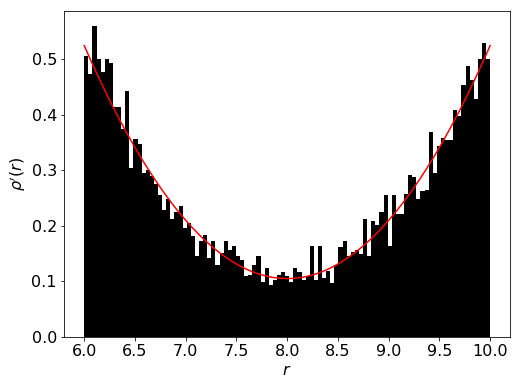

In [629]:
plt.hist(toy_sample[0],bins=x,density=True);
plt.plot(x,p(x)/np.sum(p(x))/np.diff(x)[0])
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho'(r)$")

<h3>This is also used in Monte Carlo integration, if we cannot solve the integral, for example, or for determining our posterior distributions (sampling).<br><br>
    The area of the rectangle that we chose to fill with random points is $A_{rect} = (10-6) \cdot 5 = 20$.<br>
    Now, if know the total number of points that we needed to sample to get our $10000$ accepted samples 'under the curve', we solve the integral $I = \int_6^{10}\,dr\,\left[(r-8)^2+1\right]$ numerically by Monte Carlo integration:</h3>

In [733]:
# total number of samples
N_all_points = len(toy_sample[1][:,0])
N_all_points

21352

In [734]:
# points under curve
N

10000

In [736]:
# area of rectangle
A_rect = 20
A_rect

20

In [737]:
# area under the curve
A_int = A_rect * N / N_all_points
A_int

9.366804046459348

<h3>Our estimate from $10000$ samples is $\tilde{I} \approx 9.367$. The true value is (in this case we can solve the thing analytically):  $I = \int_6^{10}\,dr\,\left[(r-8)^2+1\right] = \left[\frac{1}{3}r^3 - 8r^2 + 65r\right]_{6}^{10} = 9.333...$.<br>
    We get a relative error of $\approx 0.4\,\%$. Quite good already.</h3>

<h3>Of course, if we already know what the distribution is (in 1D), we could have used that. Now we do the same in 3D:</h3>

In [630]:
def devac(x,y,z):
    x0 = 8.178
    y0 = 0.
    z0 = -0.015
    
    a = 7.669
    re = 2.7
    r = np.sqrt((x-x0)**2+(y-y0)**2+(z-z0)**2)
    rho_b = np.exp(-a*(r/re)**(1./4.)) * (r/re)**(- 7./8.) * 2.386294537801525# ( (2/3)**4 * (a**17/np.pi**3)**(1/2) / (5**2 * 1001 * re**3) )
    return rho_b

In [631]:
def expdisk(x,y,z):
    x0 = 8.178
    y0 = 0.
    z0 = -0.015
    
    r = np.sqrt((x-x0)**2+(y-y0)**2)
    re = 3.5
    ze = 0.25
    return np.exp(-np.abs(z-z0)/ze-r/re)/(4*np.pi*re**2*ze)

In [632]:
def nova_density(x,y,z):
    val = expdisk(x,y,z)*0.9 + devac(x,y,z)*0.1
    return val

In [634]:
# target density
def p(x,y,z):
    return nova_density(x,y,z)

# proposal density (support function)
def q(x,y,z):
    return st.multivariate_normal.pdf((x,y,z),mean=(8.2,8.2,8.2),cov=((8.2,0,0),(0,8.2,0),(0,0,8.2)))

# weird
#k = max(p(x_arr,y_arr,z_arr) / q(8.2,8.2,8.2))
k = 5

# same in 3D
def nova_rejection_sampling(n=100):
    samples = []
    while len(samples) < n:
        x_tmp, y_tmp, z_tmp = np.random.multivariate_normal(mean=(8.2,8.2,8.2),cov=((8.2,0,0),(0,8.2,0),(0,0,8.2)))
        u = np.random.uniform(0, k*q(x_tmp, y_tmp, z_tmp))

        if u <= p(x_tmp, y_tmp, z_tmp):
            samples.append([x_tmp, y_tmp, z_tmp])

    return np.array(samples)

<h3>And sampling. Might take a bit, because the 3D functions take some time to evaluate.<br>
    In the end, we get sampled positions according to this difficult distribution. From this, we can calculate 'all' distances, and find a 1D distribution of distances according to the density.<br><br>
    The integral that we would have to solve to get the same answer (to a somewhat differently stated questions) is given by (this is actually the expectation value of the distance which we will need later):<br><br>
    $\iiint\,dx\,dy\,dy\,\rho(x,y,z) d(x,y,z)$<br>
    (NB: We don't need to normalise by the integral $\iiint\,dx\,dy\,dz\,\rho(x,y,z)$ because it is exactly $1$.)

In [635]:
N = 10000
nova_position_samples = nova_rejection_sampling(N)

In [636]:
# tool maybe 5 minutes?

<h3>Function for distance:</h3>

In [637]:
def distance(x,y,z):
    return np.sqrt(x**2+y**2+z**2)

In [638]:
distances = distance(nova_position_samples[:,0],
                     nova_position_samples[:,1],
                     nova_position_samples[:,2])

Text(0, 0.5, 'Number of novae at distance')

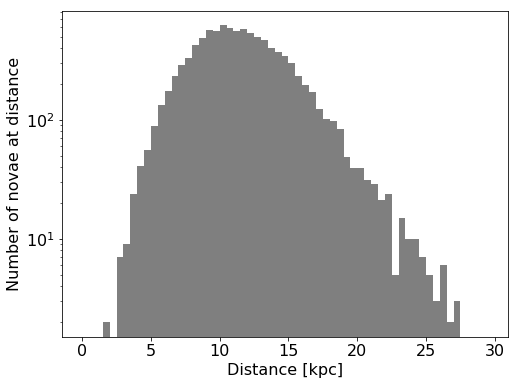

In [659]:
plt.hist(distances,bins=np.arange(0,30,0.5),alpha=0.5);
plt.yscale('log')
plt.xlabel('Distance [kpc]')
plt.ylabel('Number of novae at distance')

<h3>Who knew?<br>
    We see that in our immediate vicinity, no (very little) novae are expected to happen: I sampled $10000$ objects, and we expect $R_N=50\,\mathrm{yr^{-1}}$ in the Milky Way, so shown arer about $200$ years, in which we have $2$ objects within 2 kpc to the Sun. Very infrequent...<br>
    We now use this distribution to find a generic one that matches these points best. I did a Stan fit to the points with the Beta-distribution, and found these values to be useful:<hr>
    $d_i \propto 29.8 \cdot B(6.1,9.5)$:</h3>

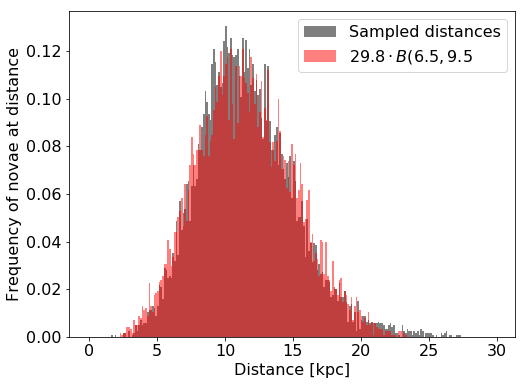

In [662]:
plt.hist(distances,bins=np.arange(0,30,0.125),density=True,alpha=0.5,label='Sampled distances');
plt.hist(np.random.beta(6.1,9.5,10000)*29.8,density=True,bins=np.arange(0,30,0.125),alpha=0.5,label=r'$29.8 \cdot B(6.5,9.5$');
plt.xlabel('Distance [kpc]')
plt.ylabel('Frequency of novae at distance')
plt.legend()

<h3>Of course, we don't exactly match the true distribution, but this is better than assuming a Gaussian function, because is has a certain skewness already included. We miss some of the very far objects (won't see anyway), and some in the peak, as ours is somewhat shifted towards higher distances (this is good because more conservative estimate).</h3>

<h3>Very long explanation of what $\rho$ is. It will return. Now<br>
    Slide 3:</h3>

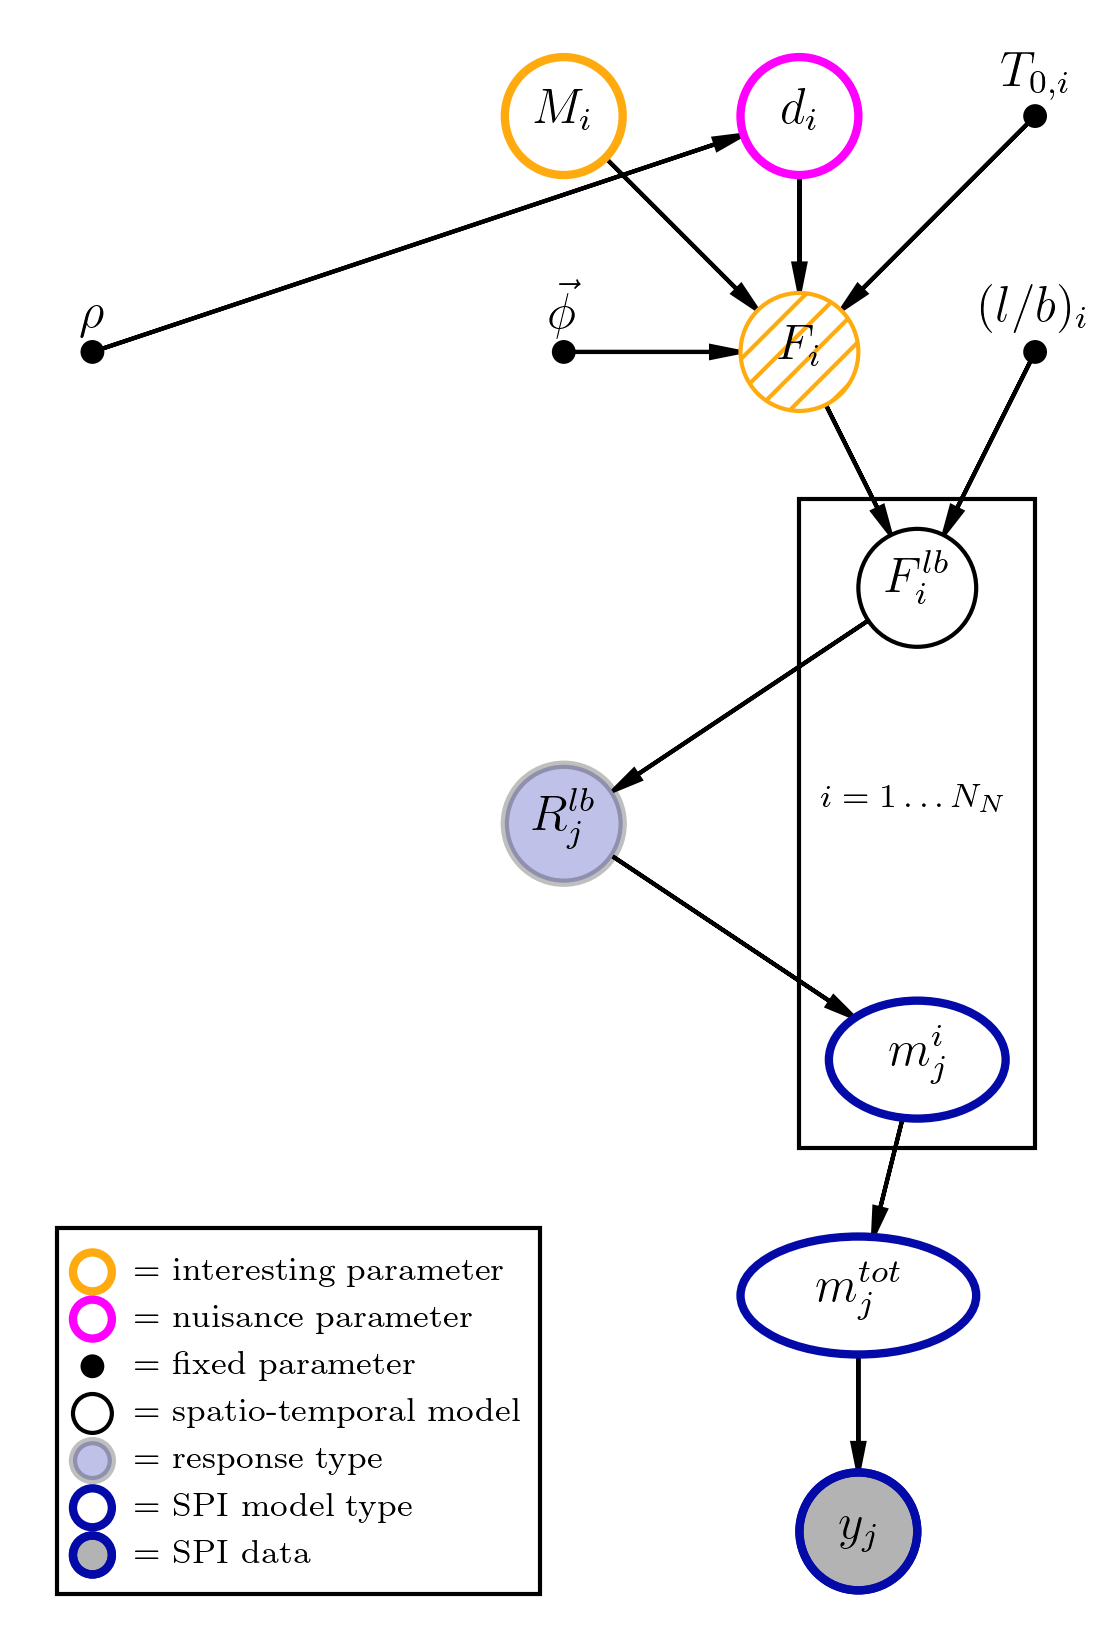

In [664]:
with open('plots/multi_nova_mass.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h3>This is quick as it just means, we sum over all our $N_N = 102$ objects to build the total model:<br><br>
    $m_j^{tot} = \sum_i^{N_N} m_j^i$.</h3>

<h3>Slide 4:</h3>

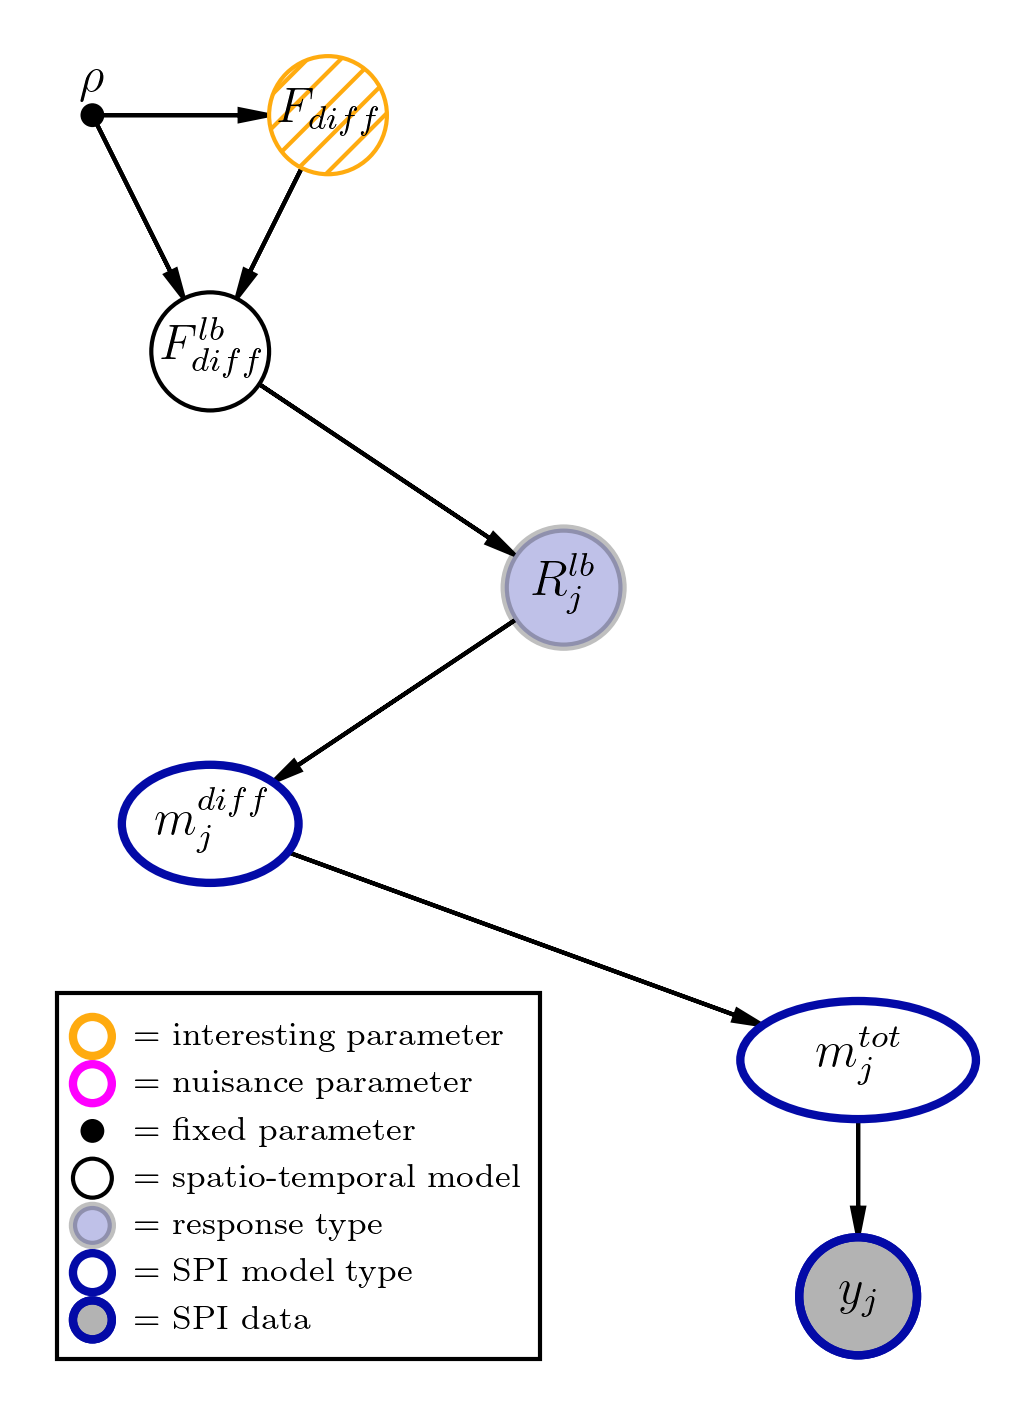

In [665]:
with open('plots/diff_nova_flux.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h3>Now the same game with the 'diffuse' emission $F_{diff}^{lb}$. This component now follows a line-of-sight integration of 'all' novae that we do <em>not</em> see. $F_{diff}^{lb}$ is then in units of $\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$ as it is distributed over the whole sky and now just in one point ($\delta$-functions from before). The total flux when integrating over the whole sky again is $\int\,d\Omega\,F_{diff}^{lb} = F_{diff}$, then again in units of $\mathrm{ph\,cm^{-2}\,s^{-1}}$.<br>
    Similar to before, we convolve our (astro)physical sky model $F_{diff}^{lb}$ with the instrument response $R_j^{lb}$ and obtain a model in SPI data space $m_j^{diff}$.</h3>

<h3>Beforer we go on to include the physics also in this part of the model, we go into this 'line-of-sight' integration:<br>
    You know that objects become fainter when further away - the inverse-distance-square-law. If you now consider to observe along one line of sight, there are (infinitely) many positions, which all show a different intrinsic luminosity (or in terms of the density, a certain 'emissivity' in units of $\mathrm{cm^{-3}\,s^{-1}}$, a number of emission particles per unit volume and time). If we integrate along this line, we obtain a total flux that is coming from this direction.<br><br>
    We parametrise the sky (in Galactic =) spherical coordinates with a radius originating form the Sun towards infinity (infinity is a large number useful for our calculations). Thus:<br><br>
    $x'(s) = x_0 - s\cos(l)\cos(b)$<br>
    $y'(s) = y_0 - s\sin(l)\cos(b)$<br>
    $z'(s) = z_0 - s\sin(b)$<br><br>
    This should look familiar.<br>
    Our flux at position $(l/b)$ is now given by<br><br>
    $F_{diff}^{lb} = \frac{1}{4\pi}\int_0^{+\infty}\,ds\,\rho(x'(s),y'(s),z'(s))$.</h3>

<h3>Easy as that...<br>
    We will (not necessarily) need to integrate this numerically:<br>
    You might need to download the python package 'numba', which also does things magically that I don't understand but parallelises code, making things a lot (!) faster.</h3>

In [666]:
import os
from numba import jit, njit, prange
from numpy import cos, sin, fabs, cosh, exp, pi, sqrt

In [667]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata

In [668]:
# solar system position in kpc
x0 = 8.178
y0 = 0
z0 = 0.01646

In [669]:
deg2rad = pi/180

<h3>Same functions as above, but now with numba included and as a function of the line of sight $s(l/b)$:</h3>

In [670]:
@jit(nopython=True)
def deVaucouleurs_gal(s,b,l):
    x0 = 8.178
    y0 = 0
    z0 = 0.01646
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    
    a = 7.669
    re = 2.7
    r = np.sqrt(x**2+y**2+z**2)
    
    rho_b = np.exp(-a*(r/re)**(1./4.)) * (r/re)**(- 7./8.) * 2.386294537801525# ( (2/3)**4 * (a**17/np.pi**3)**(1/2) / (5**2 * 1001 * re**3) )
    return rho_b

In [671]:
@jit(nopython=True)
def ExpDisk_gal(s,b,l):
    x0 = 8.178
    y0 = 0
    z0 = 0.01646
    x = x0 - s*cos(deg2rad*l)*cos(deg2rad*b)
    y = y0 - s*sin(deg2rad*l)*cos(deg2rad*b)
    z = z0 - s*sin(deg2rad*b)
    
    r = np.sqrt(x**2+y**2)
    re = 3.5
    ze = 0.25
    return np.exp(-np.abs(z)/ze-r/re)/(4*np.pi*re**2*ze)

In [672]:
# add both components
@jit(nopython=True)
def NovaDensity_gal(s,b,l):
    return 0.1*deVaucouleurs_gal(s,b,l) + 0.9*ExpDisk_gal(s,b,l)

<h3>We now go from $(x,y,z)$ to $(s,l,b)$, and finally to $(l,b)$.<br>
    We define our image by pixels as $-180^{\circ} \leq l < +180^{\circ}$ and $-90^{\circ} < b < +90^{\circ}$, repectively, with a pixel size $\Delta l = \Delta b = 1^{\circ}$, such that $\Delta \Omega = (1^{\circ})^2$. Because 'square-degrees' is sometimes not a useful unit, one can also use 'steradian' $sr = \left(\frac{180^{\circ}}{\pi}\right)^2 = (3282.81^{\circ})^2$ or $(1^{\circ})^2 = 3.046 \times 10^{-4}\,\mathrm{sr}$.<br>
    As you can read below, we need a grid also in $s$, which we choose as $20\,\mathrm{pc}$ so resolve the fine structures alone each sight line (if any):</h3>

In [673]:
# definition of image space

# minmax range for our data set is full sky
lmin,lmax = -180,180
bmin,bmax = -90,90

# SPI resolution is ~2.5 deg, here we oversample the resolution
binsize = 1
nl_pixels = 360
nb_pixels = 180
#npc = int(n_pixels/2)

# range for line of sight integration 
#srange = 6.
smin,smax = 0,25

# use resolutin of 20 pc => n_los_steps = ds / 0.02 = 1250
# also here driven empirical to get values from exact integration
n_los_steps = 1250

# define lon, lat, and los arrays, with and without boundaries
s = np.linspace(smin,smax,n_los_steps)
ds = np.diff(s)[0] # los element
bg = np.linspace(bmin,bmax,nb_pixels+1)
lg = np.linspace(lmin,lmax,nl_pixels+1)
b = (bg[1:]+bg[0:-1])/2
l = (lg[1:]+lg[0:-1])/2

# define 2D meshgrid for image coordinates
L_ARRg, B_ARRg = np.meshgrid(lg,bg)
L_ARR, B_ARR = np.meshgrid(l,b)

# define solid angle for each pixel for normalisations later
domega = (binsize*deg2rad)*(np.sin(np.deg2rad(B_ARR+binsize/2)) - np.sin(np.deg2rad(B_ARR-binsize/2)))

<h3>Here it is important to check that your sky as a surface element of $4\pi$:</h3>

In [674]:
np.sum(domega),4*pi

(12.566370614359174, 12.566370614359172)

<h3>Looks good.<br>
    Now we make a 3D grid of our $s$, $b$, and $l$ values, just as we would do with an $(x,y,z)$ grid:</h3>

In [675]:
# meshgrid for 3D space: image-los
grid_s, grid_b, grid_l = np.meshgrid(s,b,l,indexing="ij")

<h3>The next step calculates all points on the grid (which would take a lot longer if we don't use numba), i.e. we calculate<br>
    $\rho(x'(s(l,b)),y'(s(l,b)),z'(s(l,b)))$.</h3>

In [676]:
# vectorised los 3D array
los0 = cos(deg2rad*grid_b)*np.vectorize(NovaDensity_gal)(grid_s, grid_b, grid_l)

<h3>Here we sum (integrate) over $ds$, i.e. $F_{diff}^{lb} \propto \tilde{F}_{diff}^{lb} = \int\,ds \rho(s)$.</h3>

In [677]:
# calculation of flux map by integrating over ds (all ds are the same so sum is appropriate)
nova_gal_model = np.sum(los0*ds,axis=0)

<h3>And finally normalise to a flux value that we want (that we want to have determined by the fit), hence<br>
    $F_{diff}^{lb} = F_{diff}\frac{\tilde{F}_{diff}^{lb}}{\int\,d\Omega \tilde{F}_{diff}^{lb}}$.</h3>

In [679]:
# normalise flux
flux_norm = 2e-3 # chosen to be equivalent to other sources
nova_gal_model_normed = nova_gal_model / np.sum(nova_gal_model*domega) * flux_norm

<h3>Same for individual density components (not needed, but calculated for explanation purpose):</h3>

In [680]:
# vectorised los 3D array devac
los0_devac = cos(deg2rad*grid_b)*np.vectorize(deVaucouleurs_gal)(grid_s, grid_b, grid_l)
devac_gal_model = np.sum(los0_devac*ds,axis=0)
devac_gal_model_normed = devac_gal_model / np.sum(devac_gal_model*domega) * flux_norm

In [681]:
# vectorised los 3D array expdisk
los0_expdisk = cos(deg2rad*grid_b)*np.vectorize(ExpDisk_gal)(grid_s, grid_b, grid_l)
expdisk_gal_model = np.sum(los0_expdisk*ds,axis=0)
expdisk_gal_model_normed = expdisk_gal_model / np.sum(expdisk_gal_model*domega) * flux_norm

<h3>Now we have a final model map, and we can plot the full sky distribution, line-of-sight-integrated:</h3>

<h3>Reading in nova catalogue for comparison here:</h3>

In [686]:
import matplotlib.colors as colors
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u

In [687]:
import pandas as pd

In [688]:
data_frame = pd.read_csv('INTEGRAL_novae_wTimes.csv')
good_novae = np.where(~np.isnan(data_frame['IJD']) &
                      (data_frame['Dist. \n(kpc)']+data_frame['Dist. Err. (kpc)'] < 25) &
                      ((data_frame['Var. type'] == 'N') |
                       (data_frame['Var. type'] == 'NAa') | 
                       (data_frame['Var. type'] == 'NB') |
                       (data_frame['Var. type'] == 'NC') |
                       (data_frame['Var. type'] == 'NTS')))[0]

In [689]:
Nn = len(good_novae)
Nn
# 2)
c_arr = []
# 1)
for i in range(Nn):
    c = SkyCoord(ra=data_frame['Ra\n(deg)'][good_novae[i]],
                 dec=data_frame['Dec\n(deg)'][good_novae[i]],
                 unit=(u.degree, u.degree))
    c_arr.append([c.galactic.l.deg,
                  c.galactic.b.deg,
                  data_frame['l\n(deg)'][good_novae[i]],
                  data_frame['b\n(deg)'][good_novae[i]]])
# 2)
c_arr = np.array(c_arr)
c_arr[np.where(c_arr > 180)] -= 360

# 3)
ndx = 50

<h3>Map as is:</h3>

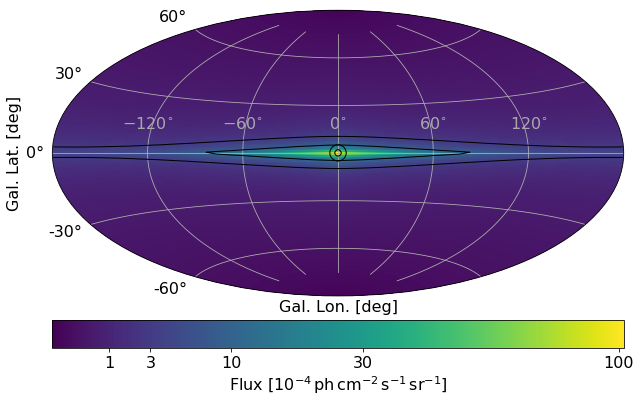

In [690]:
plt.figure(figsize=(10.24,7.68+1))
plt.subplot(projection='aitoff')

scl = 1e4

# compare contours
plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,nova_gal_model_normed*scl,
               norm=colors.PowerNorm(0.5,vmin=nova_gal_model_normed.min()*scl,
                                     vmax=nova_gal_model_normed.max()*scl))
plt.colorbar(orientation='horizontal',
             label=r'Flux [$10^{-4}\,\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$]',
             pad=0.05,
             ticks=np.array([1e-4,3e-4,1e-3,3e-3,1e-2])*scl)

cs2 = plt.contour(l*deg2rad,b*deg2rad,devac_gal_model_normed*0.0375,
                  levels=[3e-4,0.001,0.01],colors='black',linewidths=1)

cs3 = plt.contour(l*deg2rad,b*deg2rad,expdisk_gal_model_normed*(1-0.0375),
                  levels=[3e-4,0.001,0.01],colors='black',linewidths=1)


plt.xticks(np.array([-120,-60,0,60,120])*deg2rad,labels=[r'$-120^{\circ}$'+'\n',
                                                         r'$-60^{\circ}$'+'\n',
                                                         r'$0^{\circ}$'+'\n',
                                                         r'$60^{\circ}$'+'\n',
                                                         r'$120^{\circ}$'+'\n'],color='darkgray')
plt.yticks(np.array([-60,-30,0,30,60])*deg2rad)

plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid()

<h3>Not very spectacular, but a lot of work included.</h3>

<h3>And compared to our novae</h3>

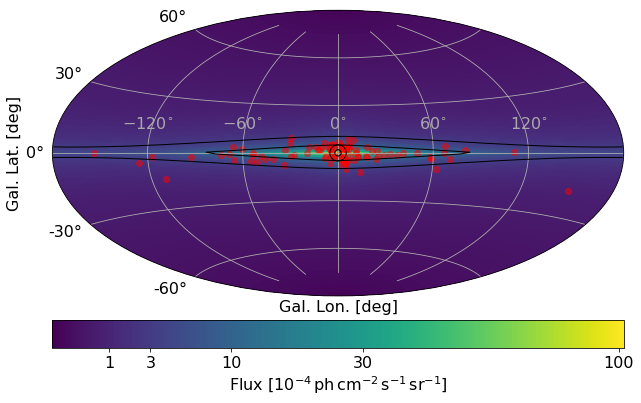

In [691]:
plt.figure(figsize=(10.24,7.68+1))
plt.subplot(projection='aitoff')

# compare contours
plt.pcolormesh(L_ARRg*deg2rad,B_ARRg*deg2rad,nova_gal_model_normed*1e4,
               norm=colors.PowerNorm(0.5,vmin=nova_gal_model_normed.min()*1e4,vmax=nova_gal_model_normed.max()*1e4))
plt.colorbar(orientation='horizontal',label=r'Flux [$10^{-4}\,\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$]',pad=0.05,
             ticks=np.array([1e-4,3e-4,1e-3,3e-3,1e-2])*1e4)#,[0.0003,0.001,0.003,0.001])

cs2 = plt.contour(l*deg2rad,b*deg2rad,devac_gal_model_normed*0.0375,
                  levels=[3e-4,0.001,0.01],colors='black',linewidths=1)

cs3 = plt.contour(l*deg2rad,b*deg2rad,expdisk_gal_model_normed*(1-0.0375),
                  levels=[3e-4,0.001,0.01],colors='black',linewidths=1)

plt.scatter(np.deg2rad(c_arr[:,0]), # aitoff  projection needs rad, not deg
            np.deg2rad(c_arr[:,1]),
            marker='o',alpha=0.5,color='red')

plt.xticks(np.array([-120,-60,0,60,120])*deg2rad,labels=[r'$-120^{\circ}$'+'\n',
                                                         r'$-60^{\circ}$'+'\n',
                                                         r'$0^{\circ}$'+'\n',
                                                         r'$60^{\circ}$'+'\n',
                                                         r'$120^{\circ}$'+'\n'],color='darkgray')
plt.yticks(np.array([-60,-30,0,30,60])*deg2rad)

plt.xlabel('Gal. Lon. [deg]')
plt.ylabel('Gal. Lat. [deg]')
plt.grid()

<h3>They do nicely follow this distribution (as expected, because they have been used to create the distribution in the first place).</h3>

<h3>Comparison of the profiles:</h3>

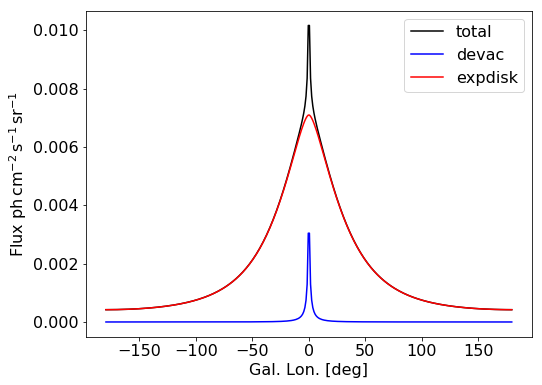

In [697]:
plt.plot(l,nova_gal_model_normed[90,:],color='black',label='total')
plt.plot(l,devac_gal_model_normed[90,:]*0.0375,color='blue',label='devac')
plt.plot(l,expdisk_gal_model_normed[90,:]*0.9625,color='red',label='expdisk')

plt.xlabel('Gal. Lon. [deg]')
plt.ylabel(r'Flux $\mathrm{ph\,cm^{-2}\,s^{-1}\,sr^{-1}}$')
plt.legend()

#plt.plot(l,devac_gal_model_normed[90,:]*0.0375+expdisk_gal_model_normed[90,:]*0.9625,color='magenta')
#plt.yscale('log')
#plt.ylim(1e-3,2e-2)
#plt.xscale('symlog')

<h3>Finally, if you want to save the file (for you for completeness):</h3>

In [698]:
import datetime
today = datetime.date.today()

In [699]:
from astropy import wcs
wcs = wcs.WCS(naxis=2)
nx = nl_pixels
ny = nb_pixels
pixscalelon = binsize # cdelt1
pixscalelat = binsize  # cdelt2

wcs.wcs.crpix = [181, 91] # Ref pixel for axis 1 and 2
wcs.wcs.cdelt = np.array([pixscalelon, pixscalelat]) # what is the pixel scale in lon, lat.
wcs.wcs.crval = [0.5,0.5] #[0.25,-0.25] #what is the galactic coordinate of that pixel.
wcs.wcs.ctype = ["GLON-CAR", "GLAT-CAR"] #CAR projection #AIT projection

In [700]:
# write wcs to fits header
header = wcs.to_header()
header['history'] = "Thomas Siegert [tsiegert@ucsd.edu] created this file on "+str(today)+" " 

# define header
hdu = fits.PrimaryHDU(np.flip(nova_gal_model_normed),header=header)

# save file
hdu.writeto('nova_gal_model_final.fits', overwrite=True)

<h3>Slide 5:</h3>

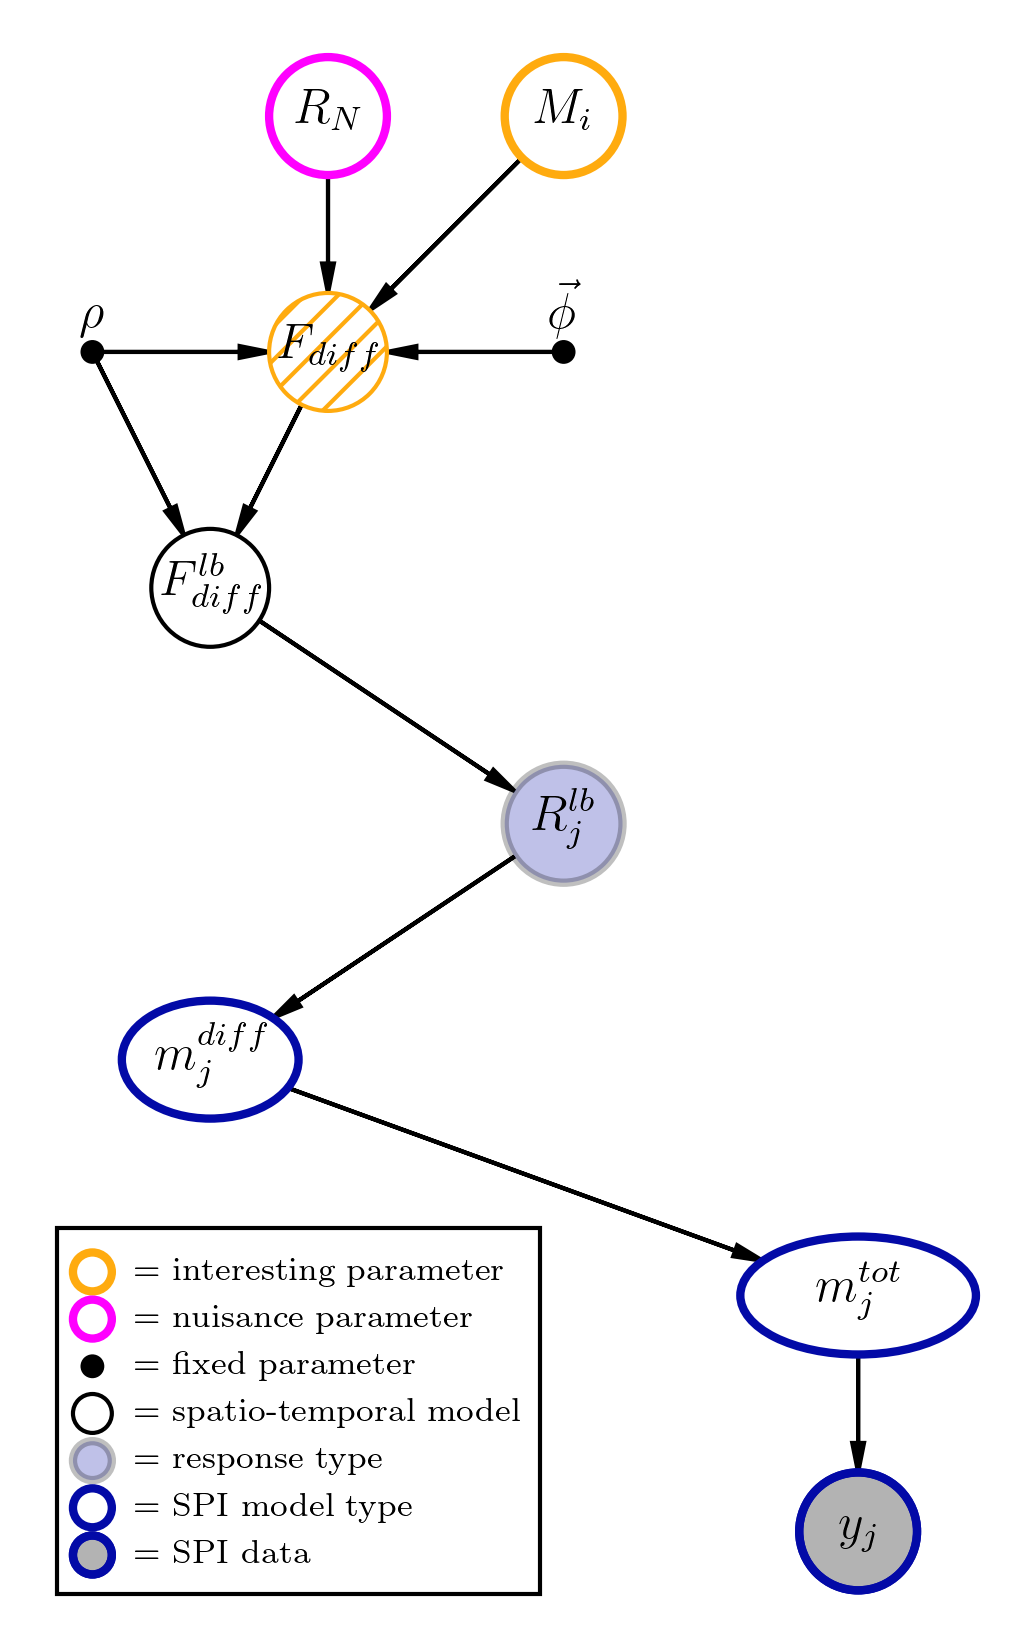

In [703]:
with open('plots/diff_nova_mass.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h3>The total diffuse flux $F_{diff}$ also depends on the ejected mass $M_i$ of individual, i.e. all, objects. Likewise, the absolute scale of this flux depends on the nova rate $R_N$, which we treat as a nuisance parameters. This means, we have some idea of what this value could be (here in particular $R_N = 50^{+31}_{-23}\,\mathrm{yr^{-1}}$, or to make it easier $R_N = 50 \pm 25\,\mathrm{yr^{-1}}$, so that we can assume a prior $R_N \propto \mathscr{N}^+(50,25)$). Likewise, the diffuse flux also depends on the nuclear constants of the decay $\vec{\phi}$ as before.<br>
    For the diffuse flux, we have to sum over <em>all</em> unknown objects $u$. Let's calculate the total luminosity first:<br><br>
    $L_{diff} = \sum_{u}^{\infty} L_u = \sum_{u}^{\infty} \frac{M_u p}{\tau m} \exp\left(-\frac{t-T_{0,u}}{\tau}\right)\Theta(t-T_{0,u})$.<br>
    (This should look familiar. It was the last things that I showed when we met in person.)<br><br>
    With $T_{0,u} = u/R_N$, we get<br>
    $L_{diff} = \frac{p \tilde{M}}{\tau m} e^{-t/\tau} \sum_{u}^{\infty} e^{u/(R_N \tau)} \Theta(t-u/R_N) \approx p R_N \frac{\tilde{M}}{m}$.<br><br>
    If and how far $M$ really depends on the object is what we want to find out, so this is why there is a tilde above the $M$ when summing over all objects.<br><br>
    The flux is calculated similarly but with the scaling of $\frac{1}{4\pi d_u^2}$, such that<br><br>
    $F_{diff} = \sum_{u}^{\infty} F_u = \sum_{u}^{\infty} \frac{M_u p}{4 \pi d_u^2 \tau m} \exp\left(-\frac{t-T_{0,u}}{\tau}\right)\Theta(t-T_{0,u}) = p R_N \frac{\tilde{M}}{m} \sum_u^{\infty} \frac{1}{4 \pi d_u^2}$.<br><br>
    This is <em>exactly</em> the same as the luminosity, scaled by a factor $\sum_u^{\infty} \frac{1}{4 \pi d_u^2}$, which we will now call $\omega$.<br>
    How do we get $\omega$? Well, we now that $d_u \propto 29.8 \cdot B(6.1,9.5)$, or, as we already sampled $10000$ $d$-values from the true distribution, we can simply calculate this 'infinite' sum (we have $10000$ values, very close to infinity):</h3>

In [704]:
iters = np.arange(1,N+1)

Text(0, 0.5, 'Effective scaling $\\omega$')

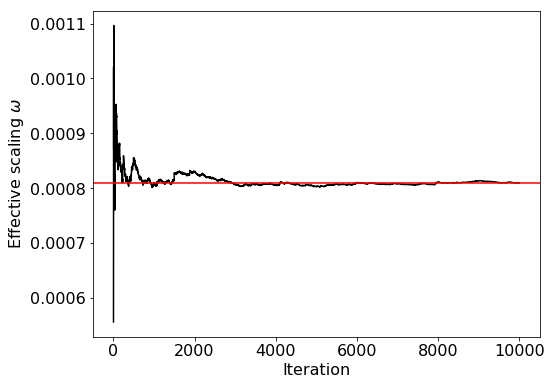

In [711]:
plt.plot(iters,np.cumsum(1/(4*pi*distances**2))/iters)
plt.axhline(np.sum(1/(4*pi*distances**2))/N,color='red')
plt.xlabel('Iteration')
plt.ylabel(r'Effective scaling $\omega$')

In [718]:
omega = np.sum(1/(4*pi*distances**2))/N
omega

0.0008100254254867441

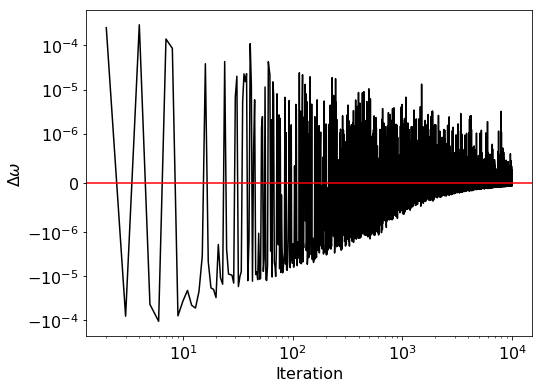

In [719]:
plt.plot(iters[1:],np.diff(np.cumsum(1/(4*pi*distances**2))/iters))
plt.axhline(0,color='red')
plt.xlabel('Iteration')
plt.ylabel(r'$\Delta \omega$')
plt.yscale('symlog',linthreshy=1e-6)
plt.xscale('log')

<h3>We nicely see that it converges to the point $\omega = 0.00081\,\mathrm{kpc^{-2}} = 8.62 \times 10^{-47}\,\mathrm{cm^{-2}}$. The sum is quasi made of alternating delta-values, so that the whole thing converges to a particular point, as also the variations per iteration get smaller. We can consider this something like an effective distance (or surface) that is scale the luminosty to get a flux - similar to the point sources, but now with the whole sky.</h3>

<h3>Slide 6:</h3>

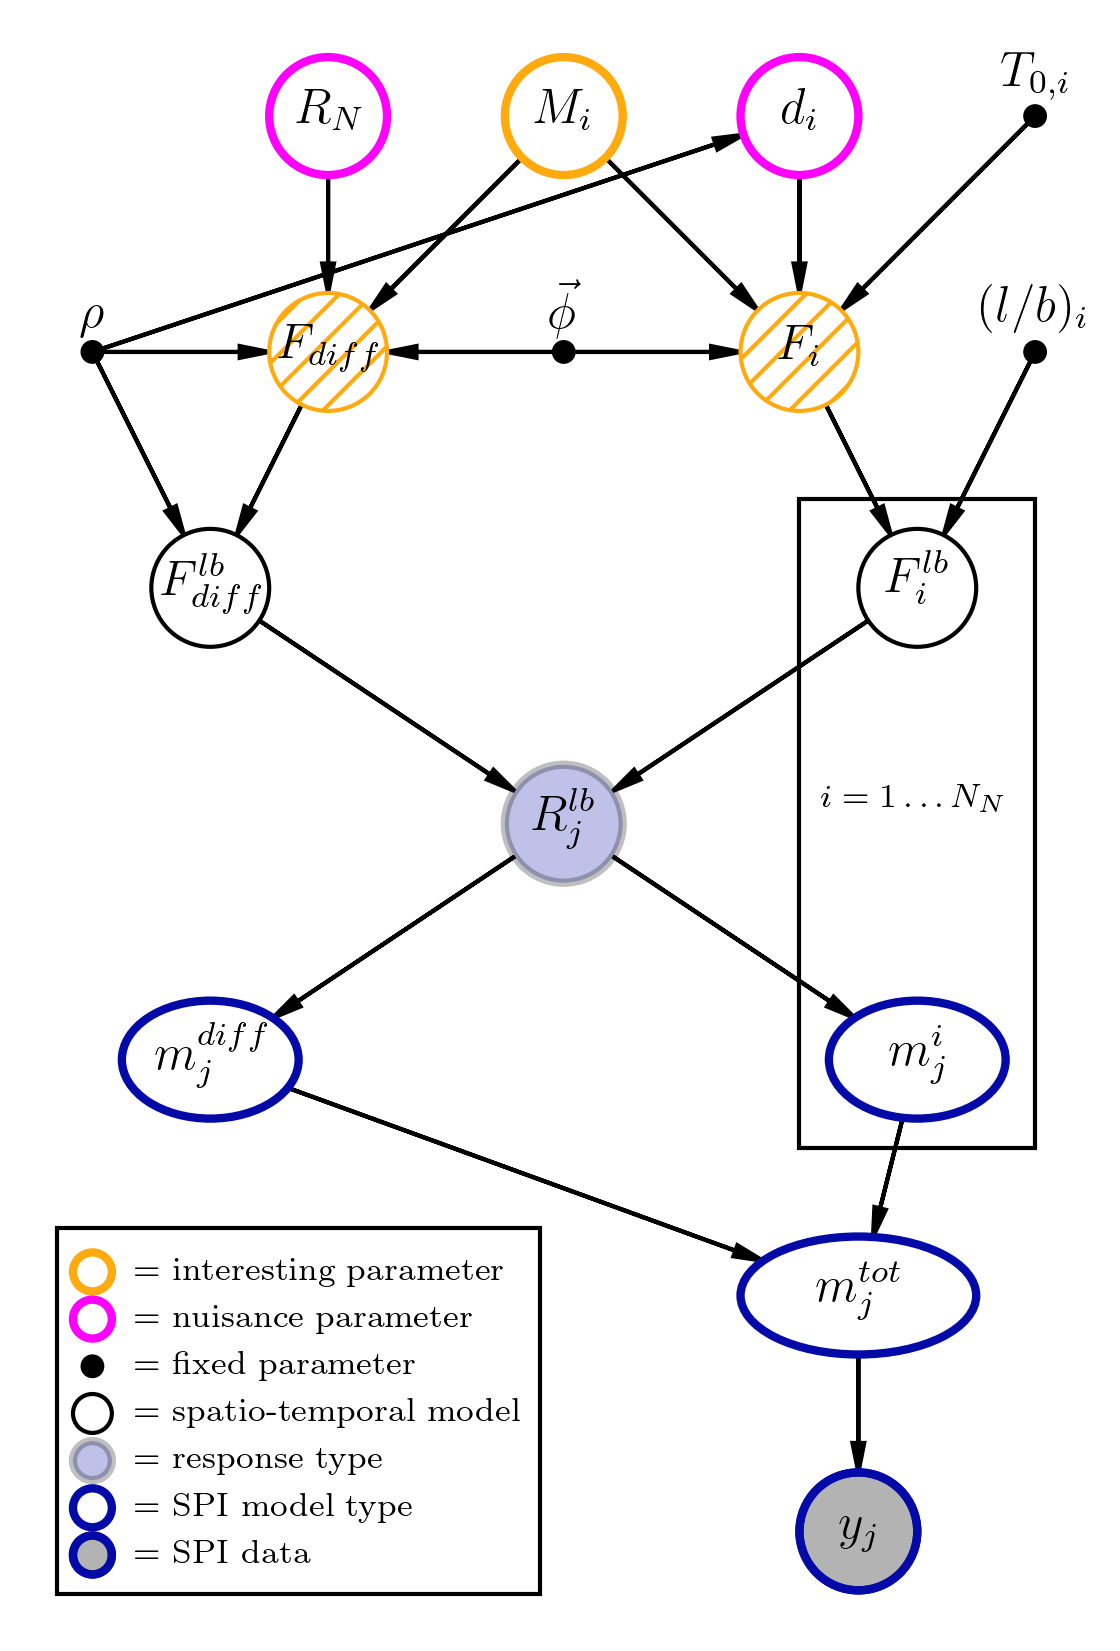

In [720]:
with open('plots/all_nova_mass.png','rb') as f:
    display(Image(data=f.read(), format='png',width=300),)

<h3>Now both sky model parts together: you see that they share the same predictor, the mass $M_i$ ejected from each object. This is what we want to fit.</h3>

<h3>Slide 7:</h3>

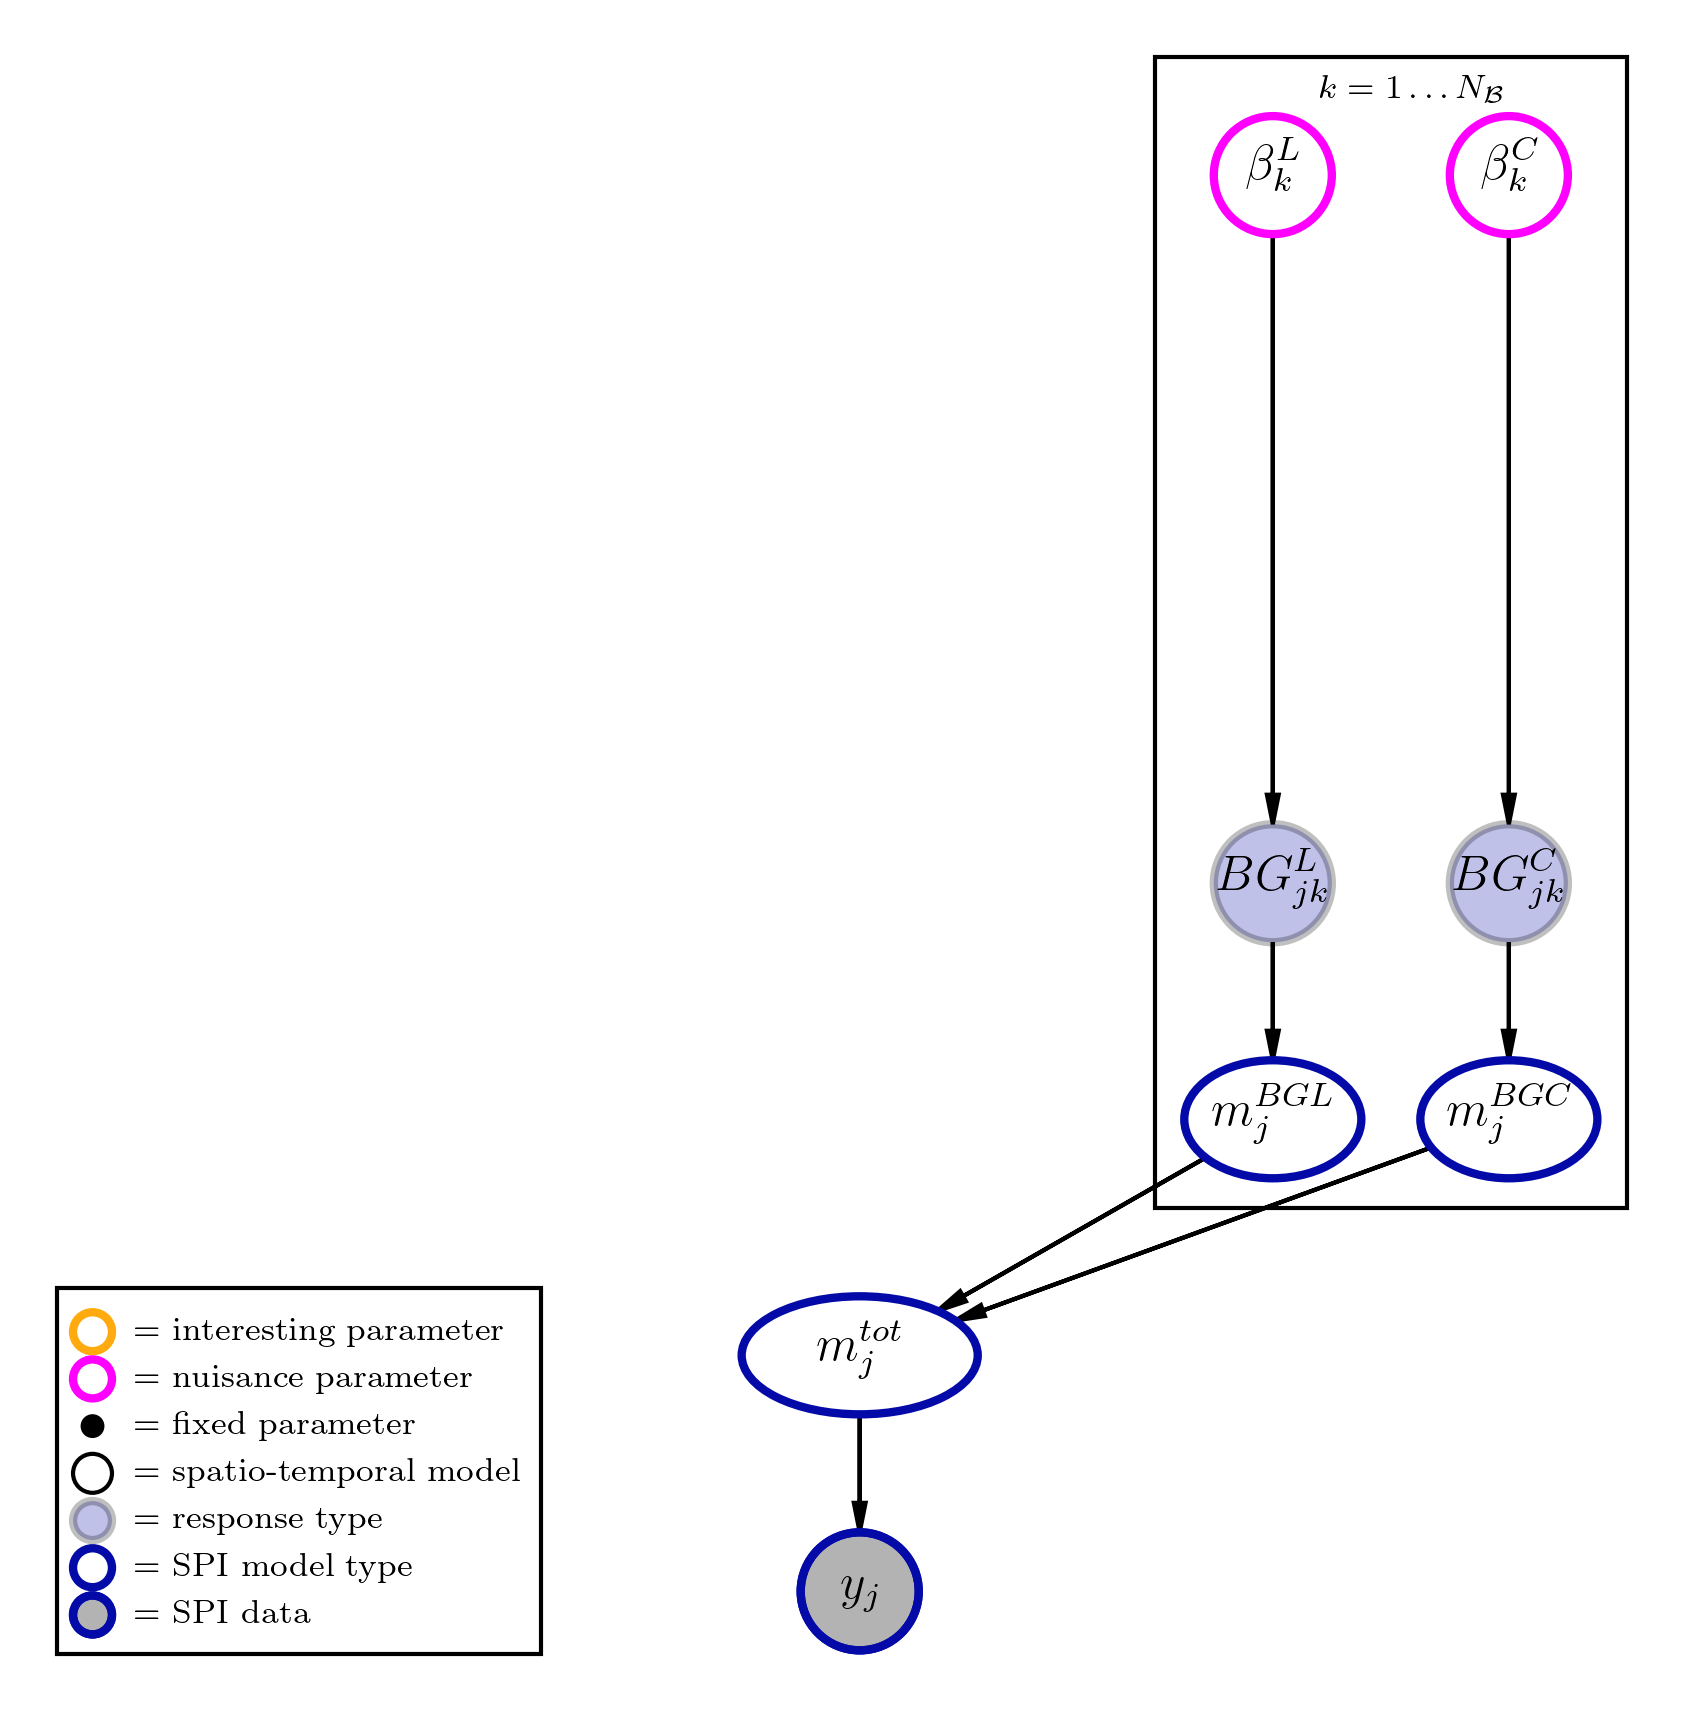

In [723]:
with open('plots/no_nova_bg.png','rb') as f:
    display(Image(data=f.read(), format='png',width=450),)

<h3>I won't go into too much detail about the background, but the idea is the same as for the sky, just it <em>does not</em> depend on $(l/b)$. Our two background models consist of $continuum$ and $line$ backgrounds, whose 'responses' $BG_k^{L,C}$ change on certain time scales, here indexed by $k$. Typically, we have time scales per one INTEGRAL orbit. Our two backgound models then are scaled in each of these time intervals $k$ by a number of background parameters $\beta_k^{L,C}$. These are important for the fit to the SPI data, but are hardly of interest in our analysis, so nuisance parameters. The total background model writes:<br><br>
    $m_j^{BG} = \sum_k^{N_B} [ \beta_k^L BG_{jk}^L + \beta_k^C BG_{jk}^C ] $.</h3>

<h3>Slide 8:</h3>

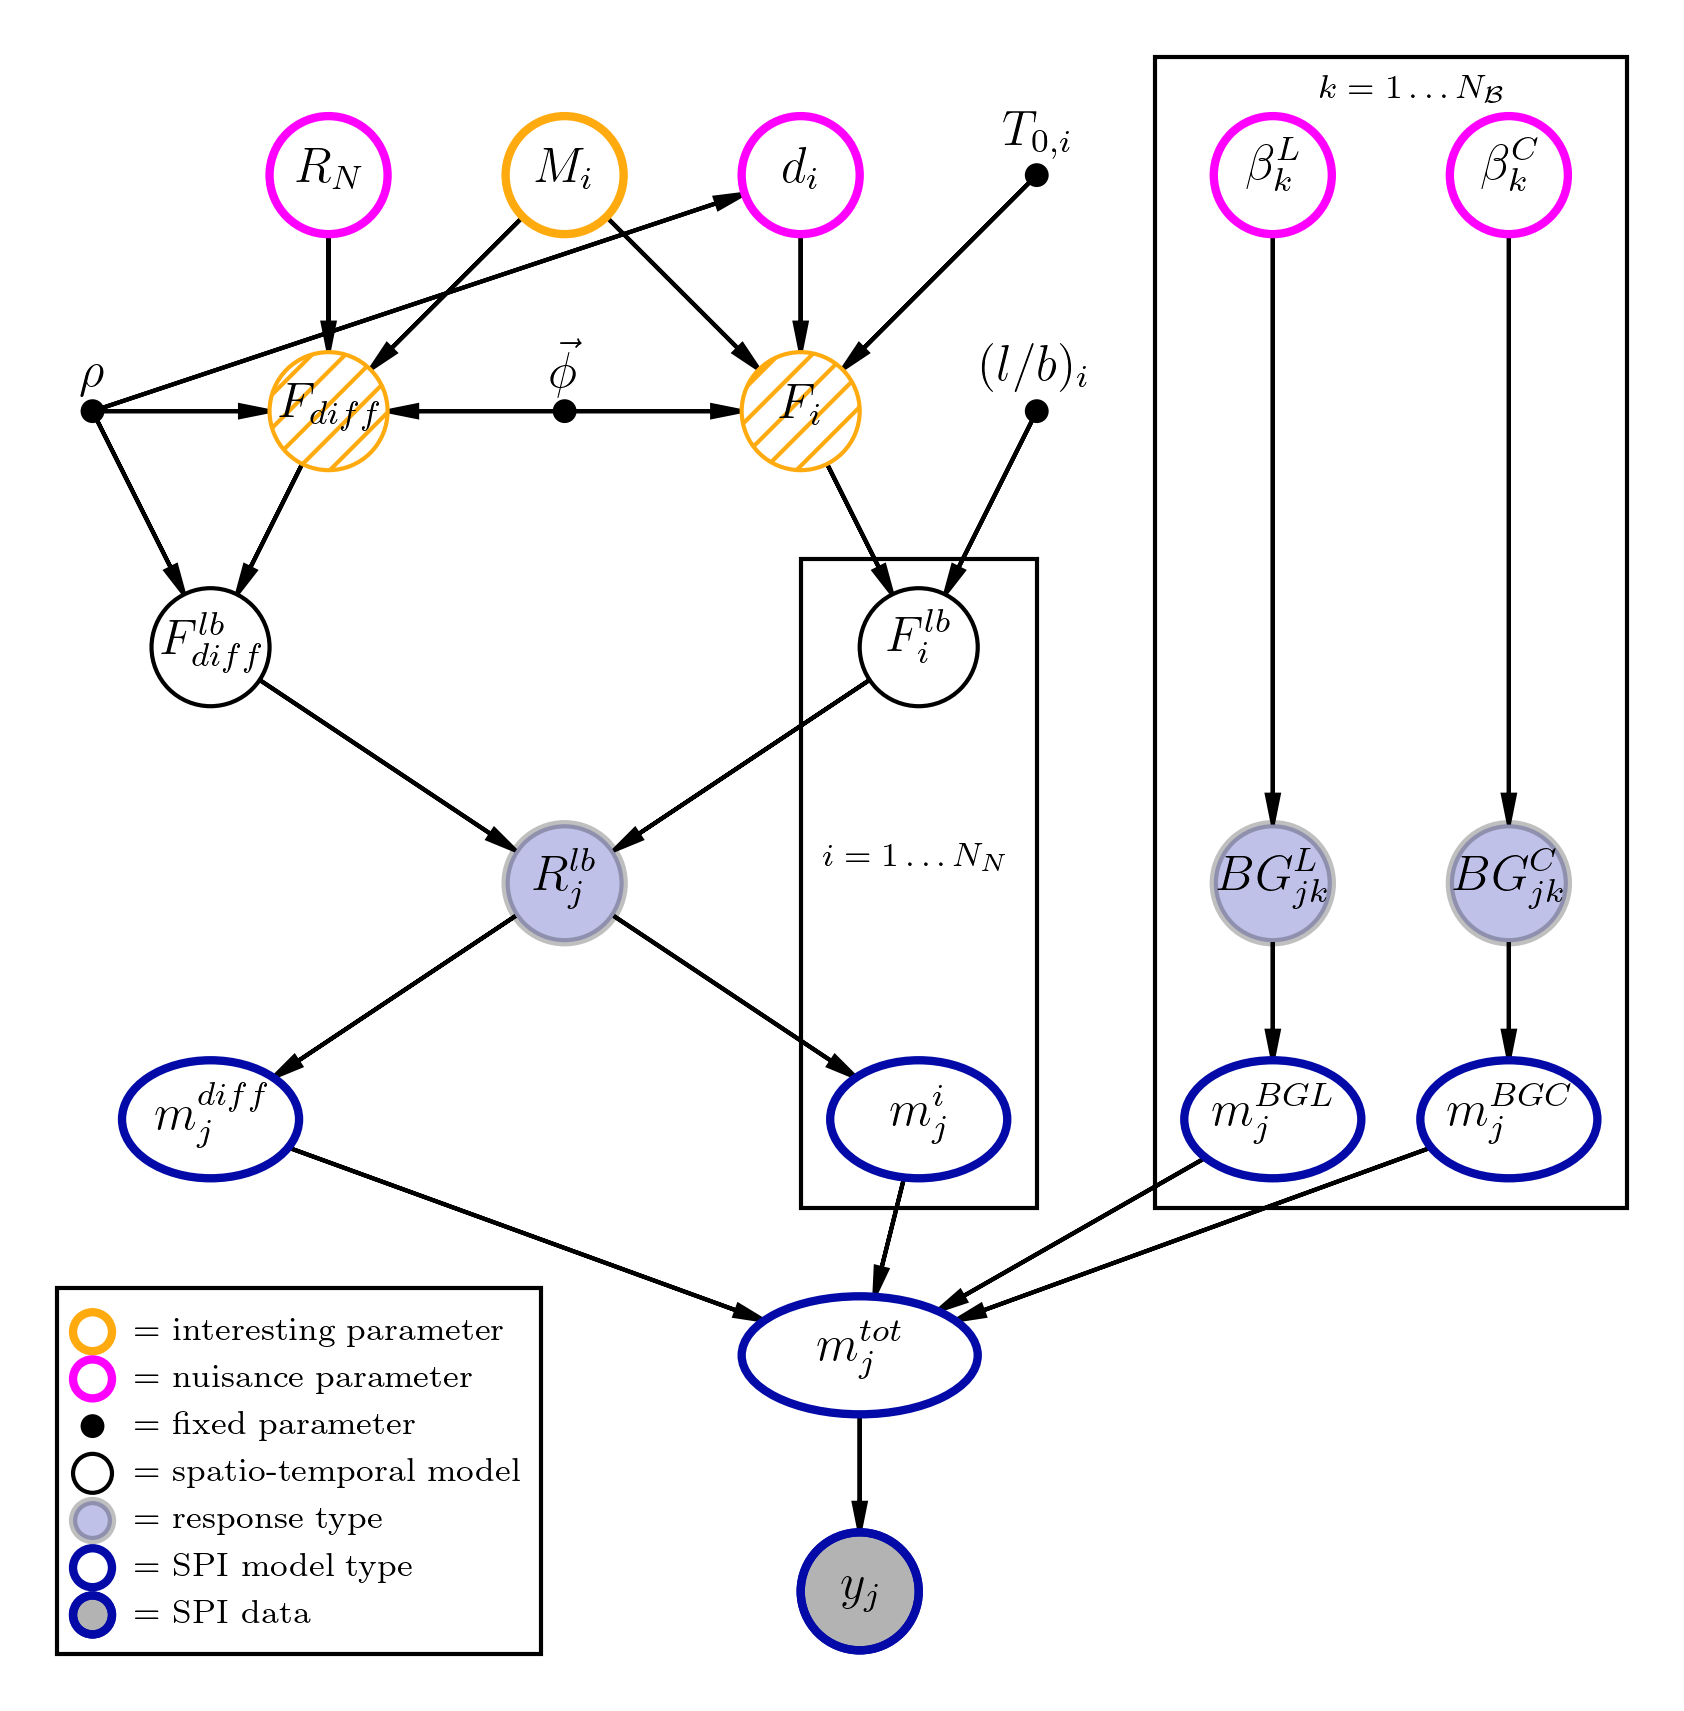

In [726]:
with open('plots/all_nova_mass_bg.png','rb') as f:
    display(Image(data=f.read(), format='png',width=500),)

<h3>This is our (almost) full model. I will not write it down in detail because, well, would be several lines long. But above, you have all the individual ingredients.<br>
    It is just important to note that everything comes down to a total model $m_j^{tot}$ that is the sum of the individual (physical or empirical) model components, which have to be convolved through the correct responses, and which might depend on each other.<br><br>
    The other important thing to note is that all sky components are linked to the mass $M_i$ trough one or the other way. From this we can then include another step in this hierarchy:</h3>

<h3>Slide 9:</h3>

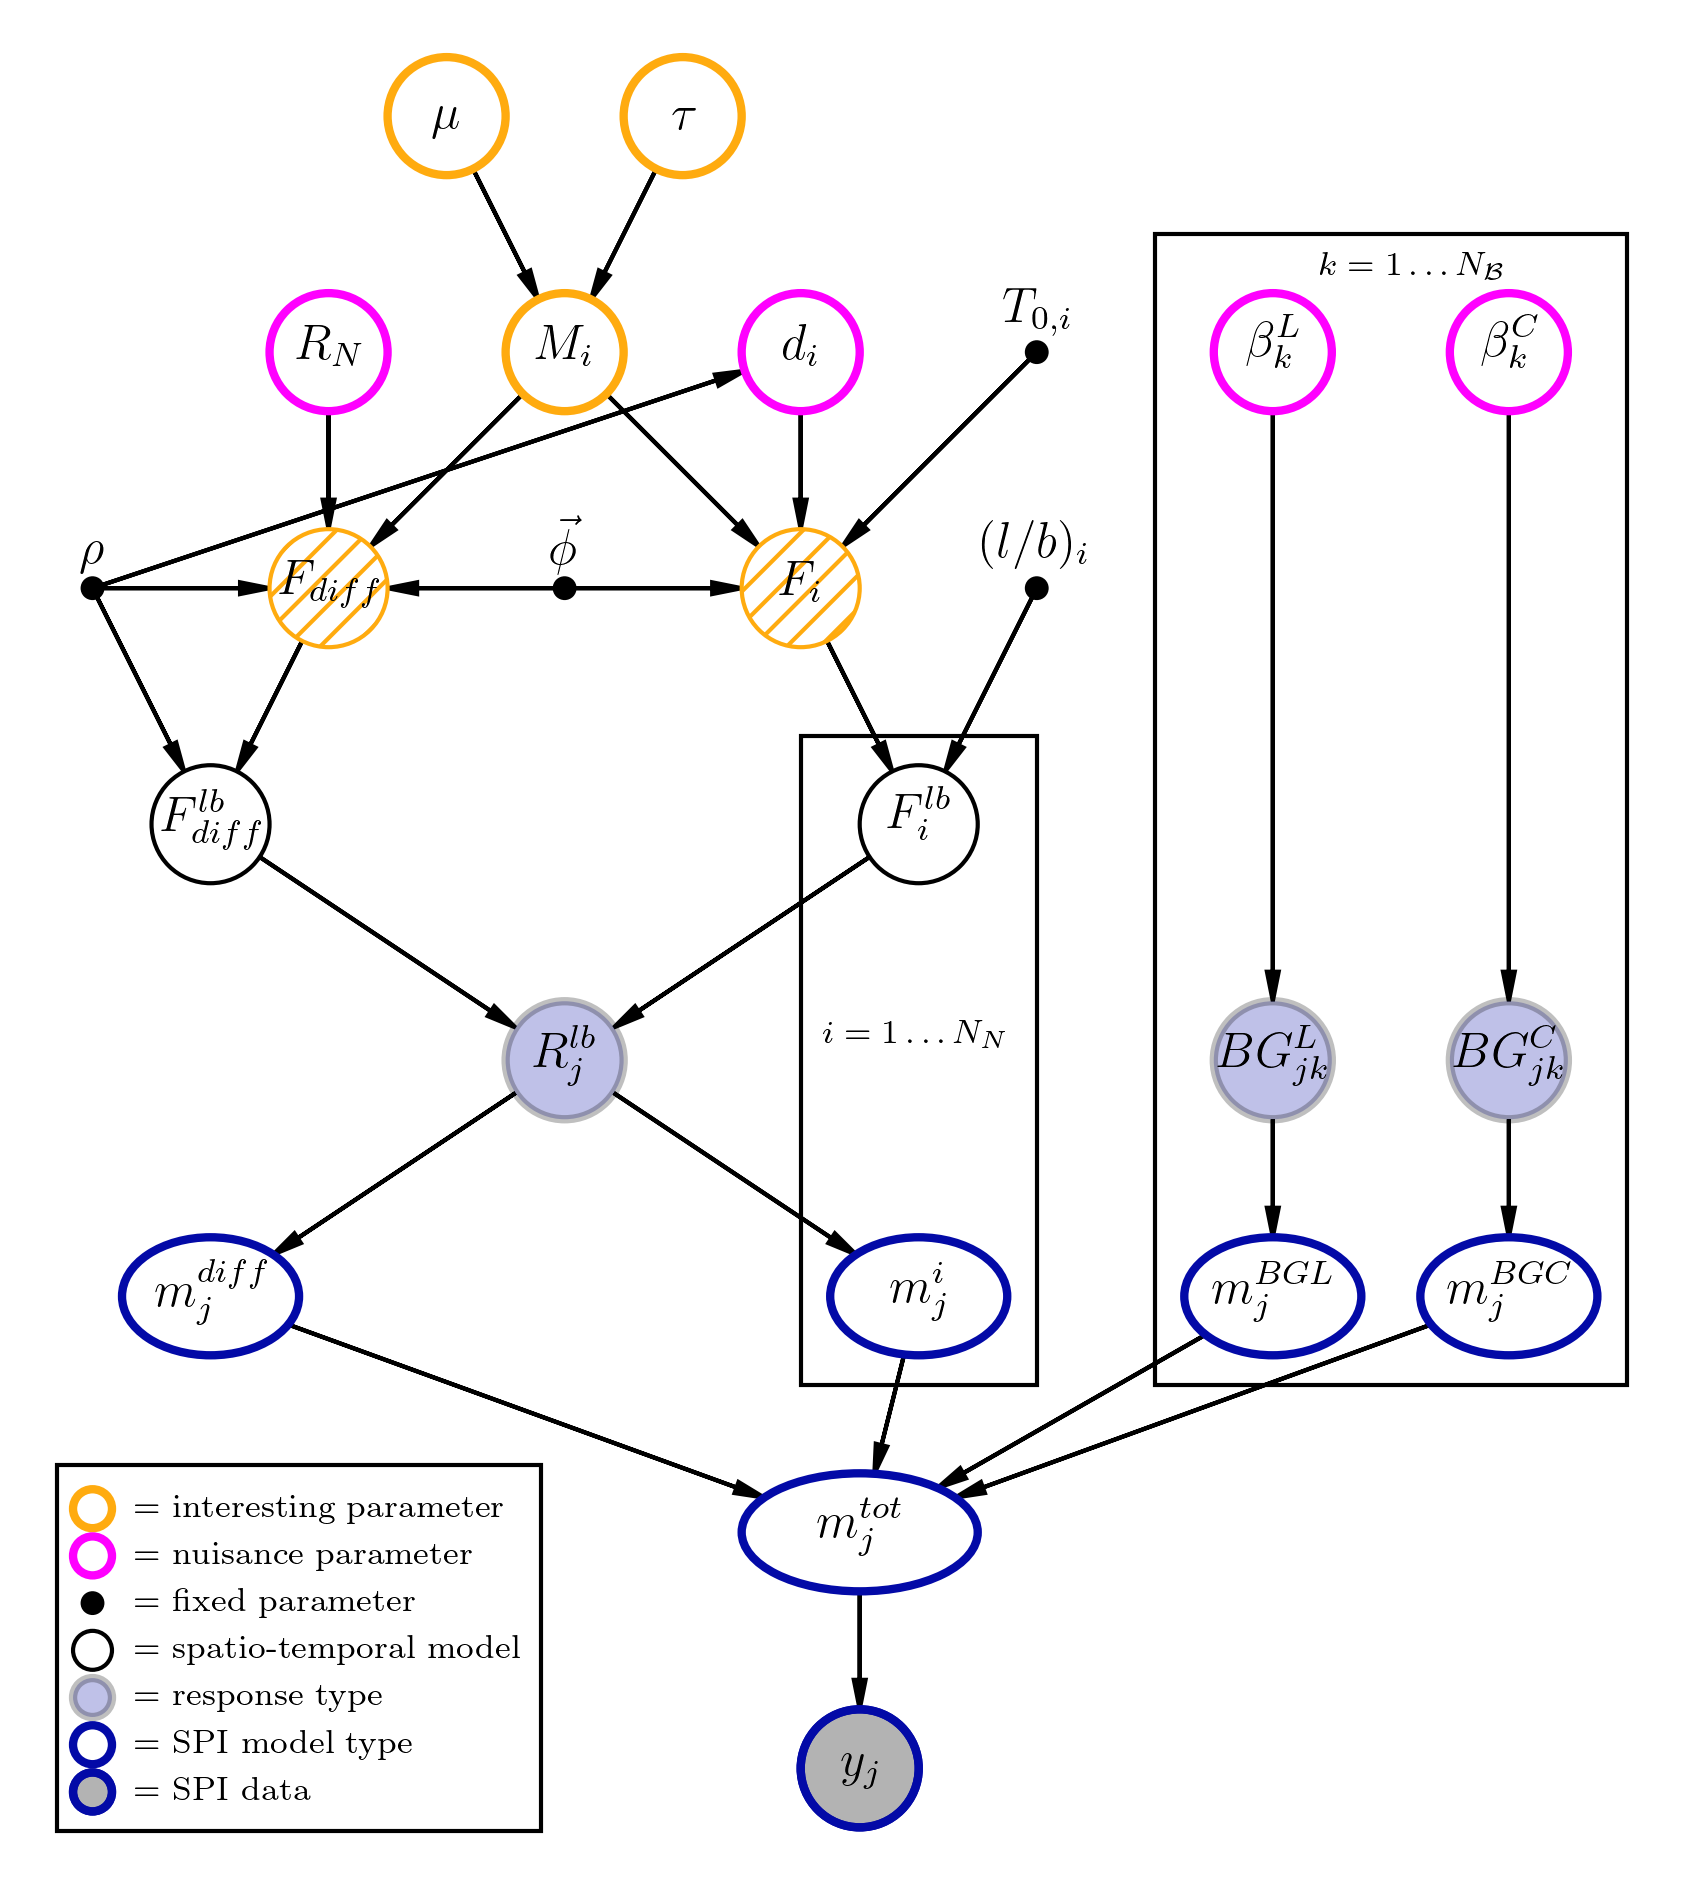

In [728]:
with open('plots/alldiff_nova_mass_bg.png','rb') as f:
    display(Image(data=f.read(), format='png',width=600),)

<h3>In this final step, I introduced two new paramters, $\mu$ and $\tau$, that tell $M_i$ how to behave when drawn from a population (as in our nova population). In detail, $\mu$ is the mean (expectation) value of ejected mass per nova event, and $\tau^2$ is the 'within-group-variance', i.e. how strong do the ejected masses change between different objects. In particular, $\lg{M_i} \propto \mathscr{N}(\mu,\tau)$.<br><br>
    There are three possibilities that we want to study in the end:<br>
    <ol>
        <li>No pooling: Each nova (and the diffuse emission) is treated independently.<br>
        This means $\tau \rightarrow +\infty$ as we assume no connection between the objects, and $\mu$ has no particular meaning.<br>
        This is useful to understand the individual strengths of objects, but since we have no strong information for any of them, this will only provide independent upper limits of sorts, given the actual observing strategy of INTEGRARL.</li>
        <li>Complete pooling: Each nova (and the diffuse emission) ejected the same mass $M_i = M$.<br>
        This means $\tau \rightarrow 0$ and $\mu = M$.<br>
        This is useful when one <em>can</em> be sure that the physics are actually the same, or to fish for some signal, if they are individually low. It also greatly reduces the number of parameters in the end.</li>
        <li>Partial pooling: Each nova (and the diffuse emission) share a common underlying distribution, and not every object does exactly the same.<br>
        This is a compromise between the first two cases is is typically called 'Bayesian hierarchical model'. We actually <em>want to know</em> what $\mu$ and $\tau$ are - especially for when the population can tell us more about the physics that an individual object (which we cannot see...).<br>
        In particular, $\mu$ and $\tau$ are called 'hyper-parameters', which require a lot of domain expertise to understand in detail for each problem. We will use nova model calculations that predict the ejected mass in the range $10^{-10}$-$10^{-7}\,\mathrm{M_{\odot}}$, so that we can set a prior on $\mu \propto \mathscr{U}(-11,-6)$. This then includes also regions which are not predicted, but could still be possible.<br>
        For the inbetween variance $\tau$, the choice is a bit more difficult, and we want our result to not depend on the choice of $\tau$. For this reason, we use a prior that peaks at $0$, but with large tails on the positive side (negative not allowed, it's a variance). Half-Cauchy priors are suitable for this: $\tau \propto \mathscr{C}_0^+(0,1)$.</li>
    </ol>